# NLP981 Final Project - Phase #1

*   Instructor: Javad PourMostafa
*   Teaching Assistant: Parsa Abbasi
*   University of Guilan, 1st semester of 2019
*   GitHub repository : *https://github.com/JoyeBright/NLP*

In [1]:
!pip install nltk
!pip install hazm
!pip install stopwords_guilannlp
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 317kB 5.6MB/s 
     |████████████████████████████████| 1.4MB 17.7MB/s 
     |████████████████████████████████| 235kB 24.3MB/s 
  Created wheel for nltk: filename=nltk-3.3-cp36-none-any.whl size=1394468 sha256=76faa268a0f1ccec86a9f92492ce6e8fac863864e4476b54d2050b1625744218
  Stored in directory: /root/.cache/pip/wheels/d1/ab/40/3bceea46922767e42986aef7606a600538ca80de6062dc266c
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp36-cp36m-linux_x86_64.whl size=154867 sha256=7090dc43a0e29344134db88d28d2a532766d8eea2bcc17955477fb1819ad0ad4
  Stored in directory: /root/.cache/pip/wheels/66/15/54/4510dce8bb958b1cdd2c47425cbd1e1eecc0480ac9bb1fb9ab
Successfully built nltk libwapiti
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
sentence = "Hello, world!"
print (nltk.word_tokenize(sentence))

['Hello', ',', 'world', '!']


It's the first phase of your final project for the *NLP981* course. The main idea behind this phase is to portray the develope side of *NLP*.

You must code inside of this python notebook. I highly recommend you to use the *Google Colab* environment. 

If you have any questions, feel free to ask.
You can use [*Quera*](https://quera.ir/course/4385/) platform for your general questions.



## Introduction

A category predictor is going to build at this phase of the project.

The predictor gets a text as input and predicts a category for that.

For this purpose, you need to :

1.   Load the dataset
2.   Preprocess the text data
3.   Implement a word representation method to represent each text as a numeric vector
4.   Implement a classification model and train that using the training set
5.   Predict a category for each of validation data using implemented model
6.   Measure your work using confusion matrix and some common metrics

**Important Note:** You can use any library you want in sections 1 and 2. But everything in section 3-6 need to be coded purely.



## 1) Dataset

The dataset you will use in this phase is called *Divar* that released by the *CafeBazaar* research team.

It contains more than 900,000 posts of the *Divar* ads platform. We split this dataset into training, validation, and testing sets.

The testing set is not accessible for you, and we use them to evaluate your work on the presentation day.

You can download the dataset files (training and validation sets) directly from the following link :

> *https://drive.google.com/open?id=1oj-fqpymjDr8QsOK-zQliiqXbVqakrFo*


### 1.1) Import

In [4]:
import pandas as pd
#from __future__ import unicode_literals
from hazm import *
from stopwords_guilannlp import *
from nltk.tokenize import RegexpTokenizer
import numpy as np
import math
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb
from mpl_toolkits.axes_grid1 import make_axes_locatable
from copy import deepcopy
from string import punctuation
import random
    
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#train_set = pd.read_csv('trainset.csv')
#valid_set = pd.read_csv('validationset.csv')

link = 'https://drive.google.com/open?id=1-D-AmUvc2fFOs53HWxoSRpy-6MtTlHRc'
st, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('trainset.csv')  
train_set = pd.read_csv('trainset.csv')

link = 'https://drive.google.com/open?id=1-J4-W7HPdDowThY24hUoqCQGDW7iUNcN'
st, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('validationset.csv')  
valid_set = pd.read_csv('validationset.csv')



### 1.2) Analyzing

Display the top 10 rows of the train set.

In [5]:
print(train_set.head(10))

   Unnamed: 0  Unnamed: 0.1  archive_by_user                   brand                cat1                       cat2            cat3     city      created_at                                               desc              id  image_count   mileage platform     price                                     title   type  year
0           0        282086             True                     NaN            personal         clothing-and-shoes  shoes-belt-bag   Tehran     Monday 11AM  چکمه یکبار پوشیده شده قیمت 42\nکفش قهوه ای سوخ...  12875614029625            3       NaN   mobile     42000                                   سایز 40  women   NaN
1           1        762753             True        Samsung::سامسونگ  electronic-devices              mobile-tablet   mobile-phones   Tehran  Wednesday 12PM  گوشی رو تا حالا باز نکردم و تو جعبه پلمپه از د...  16051997226596            0       NaN   mobile    850000                      گوشی سامسونگ a3 2016    NaN   NaN
2           2        805240          

How many data (rows) stored in the training and validation sets?

In [ ]:
train_len = train_set.shape[0]
valid_len = valid_set.shape[0]
print('Train set has {} rows.'.format(train_len))
print('Validation set has {} rows.'.format(valid_len))

Train set has 700000 rows.
Validation set has 147635 rows.


How many posts are in each category (First level categories)? (Based on training set)

In [ ]:
cat1 = train_set["cat1"]
#cat2 = train_set["cat2"]
#cat3 = train_set["cat3"]

#Test set = Valid set
test_cat1 = valid_set["cat1"]
#test_cat2 = valid_set["cat2"]
#test_cat3 = valid_set["cat3"]

unique_cat1 = np.unique(cat1)

#in the following lines of code we print how many posts are in each category
cat1_posts_count = dict.fromkeys(unique_cat1, 0)
for cat in cat1:
  cat1_posts_count[cat] += 1

for cat, cnt in cat1_posts_count.items():
  print('Category "{}" contains {} posts.'.format(cat, cnt))

dic_cat1 = {}
for i in range(len(unique_cat1)):
    dic_cat1[unique_cat1[i]] = i

y_train_cat1 = []
y_test_cat1 = []
for i in range(len(cat1)):
    y_train_cat1.append(dic_cat1[cat1[i]])
    
for i in range(len(test_cat1)):
    y_test_cat1.append(dic_cat1[test_cat1[i]])

y_train_cat1 = np.array(list(y_train_cat1))
y_test_cat1 = np.array(list(y_test_cat1))

#print(y_test_cat1)
    
    

Category "businesses" contains 45660 posts.
Category "electronic-devices" contains 122905 posts.
Category "for-the-home" contains 214955 posts.
Category "leisure-hobbies" contains 61676 posts.
Category "personal" contains 102804 posts.
Category "vehicles" contains 152000 posts.


## 2) Preprocessing

There are two kinds of text data in the dataset: *Title* and *Description*.
You can use one or both of them as text inputs of your classification model. Choose a composition that gives you a higher measuring score.

You need to apply some preprocessing procedures on your text data first. We want at least **4** preprocessing step from you. It can be removing stop words, removing punctation, removing or replacing digits, stemming, lemmatizing, normalization, and so on.

You can use the [*Stopwords Guilan NLP*](https://github.com/JoyeBright/stopwords_guilannlp) library to access a collection of Persian stop words.

In [ ]:
#for faster result, we define the following lines of code outside the 'preprocessing' function
normalizer = Normalizer()
stopwords = stopwords_output("Persian", "nar")
lemmatizer = Lemmatizer()
stemmer = Stemmer()


def preprocessing(text):
    
    text = re.sub('<[^<]+?>','', text)
    text = ''.join(c for c in text if not c.isdigit())
    text = ''.join(c for c in text if c not in punctuation)
    text = normalizer.normalize(text)
    tokens = word_tokenize(text)
    cleared_text = []
    for word in tokens:
          word = normalizer.normalize(word)
          word = stemmer.stem(word)
          word = lemmatizer.lemmatize(word)
          #word = re.sub(r'\d+', '', word)
          if word not in stopwords and len(word) > 0:
                cleared_text.append(word)
    return cleared_text


   

## 3) Word Representation

As you know, classification models can't deal with strings directly, and you have to represent your texts in a numerical form.

### 3.1) Tf-idf

You have to implement the tf-idf vectorization method from scratch in this step. 

Furthermore, a function must be implemented that gives a text input and return a tf-idf vectorized representation.

$$\text{tf-idf}(t, d) = \text{tf}(t, d) \times \text{idf}(t)$$

*tf* (term-frequency) is the count of occurrences of the word `t` in specific text `d`.

*idf* (inverse document-frequency) is term that is inversely proportional to the number of texts with the given word. It can be calculated this way:
$$\text{idf}(t) = \text{log}\frac{1 + n_d}{1 + n_{d(t)}} + 1$$
where $n_d$ is the whole number of texts and $n_{d(t)}$ is the number of texts with the word `t`.

In [ ]:
column1 = "title"
column2 = "desc"
rows_of_train = 7350
rows_of_test = 1750
docs1 = train_set.loc[0:rows_of_train-1,column1]
docs2 = train_set.loc[0:rows_of_train-1,column2]
test_docs1  = valid_set.loc[0:rows_of_test-1,column1]
test_docs2 = valid_set.loc[0:rows_of_test-1,column2]
logistic_classifiers = []
num_classes = len(unique_cat1)
losses = []
#BoW
bow1 = []
bow2 = []
bow_test1 = []
bow_test2 = []
for i in range(len(docs1)):
    bow1.append(preprocessing(docs1[i]))
    bow2.append(preprocessing(docs2[i]))
    #print('Documents train {} preprocessed.'.format(i+1))
    
for i in range(len(test_docs1)):
    bow_test1.append(preprocessing(test_docs1[i]))
    bow_test2.append(preprocessing(test_docs2[i]))
    #print('Documents test {} preprocessed.'.format(i+1))

#print(bow)

unique_words1 = set(bow1[0]).union(set(bow1[1]))
unique_words2 = set(bow2[0]).union(set(bow2[1]))
unique_words_test1 = set(bow_test1[0]).union(set(bow_test1[1]))
unique_words_test2 = set(bow_test2[0]).union(set(bow_test2[1]))


for i in range(2,len(docs1)):
    unique_words1 = set(bow1[i]).union(set(unique_words1))
    unique_words2 = set(bow2[i]).union(set(unique_words2))

for i in range(2,len(test_docs1)):
    unique_words_test1 = set(bow_test1[i]).union(set(unique_words_test1))
    unique_words_test2 = set(bow_test2[i]).union(set(unique_words_test2))
    
unique_words1 = set(unique_words1).union(set(unique_words_test1))
unique_words2 = set(unique_words2).union(set(unique_words_test2))
unique_words = set(unique_words1).union(set(unique_words2))

del unique_words1
del unique_words2
del unique_words_test1
del unique_words_test2

#print(unique_words)


#Now we create a dictionary for each document in TrainSet and TestSet
Docs1 = []
Docs2 = []
Test_Docs1 = []
Test_Docs2 = []

for i in range(len(docs1)):
    Docs1.append(dict.fromkeys(unique_words, 0))
    Docs2.append(dict.fromkeys(unique_words, 0))

del docs1

for i in range(len(test_docs1)):
    Test_Docs1.append(dict.fromkeys(unique_words, 0))
    Test_Docs2.append(dict.fromkeys(unique_words, 0))

del docs2

for i in range(len(bow1)):
    for word in bow1[i]:
        Docs1[i][word] += 1
    for word in bow2[i]:
        Docs2[i][word] += 1
        
for i in range(len(bow_test1)):
    for word in bow_test1[i]:
        Test_Docs1[i][word] += 1
    for word in bow_test2[i]:
        Test_Docs2[i][word] += 1
del bow1
del bow2
del bow_test1
del bow_test2   
    
#TF = (Frequency of the word in the sentence) / (Total number of words in the sentence)
def tf(doc):
    doc_tf = dict.fromkeys(doc.keys(), 0)
    s = sum(doc.values())
    if s > 0 :
        for word, cnt in doc.items():
             doc_tf[word] = float(cnt / s )

    return doc_tf



#IDF: (Total number of sentences (documents))/(Number of sentences (documents) containing the word)
def idf(docs):
    #number of documents
    nd = len(docs)
    docs_idf = dict.fromkeys(docs[0].keys(), 0)
    for doc in docs:
        for word, cnt in doc.items():
            if cnt > 0:
                docs_idf[word] += 1
                
    for word, cnt in docs_idf.items():
        docs_idf[word] = math.log(float(float(1+nd)/float(1+cnt))) + 1
    return docs_idf


In [ ]:
#Finally, the TF-IDF values are calculated by multiplying TF values with their corresponding IDF values.
def tf_idf_compute(tf, idfs):
    tf_idf = {}
    for word, value in tf.items():
        tf_idf[word] = value * idfs[word]
    #returns tf_idf 
    return tf_idf



def tf_idf(text):
    tf_idfs = []
    text_tfs = []
    for doc in text:
        text_tfs.append(tf(doc))
    text_idfs = idf(text)
    for i in range(len(text)):
        tf_idfs.append(tf_idf_compute(text_tfs[i], text_idfs))
        #print('Document {} tf_idf computed.'.format(i+1))
    
    #returns tf_idf vectors
    return tf_idfs



## 4) Classification

![alt text](https://cdn.lynda.com/course/578082/578082-637075371482276339-16x9.jpg)

### 4.1) Logistic Regression

The Logistic Regression classifier must be implemented from scratch here.

You can fit the training data into the classifier after implementing linear regression.

In [ ]:
#Logistic regression methods and requirements
def linear_mult(X, w, b):
    return np.dot(w.T, X) + b

def init_with_zeros(dimension):
    w = np.zeros((dimension,1))
    b = 0
    return w, b

#Sigmoid activation function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def cost_function(y, a):
    return -np.mean(y*np.log(a) + (1-y)*np.log(1-a))

def forward_propagation(w, b, X, Y):
    m = X.shape[1]
    Z = linear_mult(X, w, b)
    A = sigmoid(Z)                                 
    cost = cost_function(Y, A)  
    cost = np.squeeze(cost)    
    back_require = {
        'A': A
    }
    return back_require, cost

def backward_propagation(b, X, Y, back_require):   
    m = X.shape[1]
    A = back_require['A']
    dw = (1/m) * np.dot(X,(A-Y).T)
    db = (1/m) * np.sum(A - Y)
  
    grads = {"dw": dw,
             "db": db}
    
    return grads

def propagate(w, b, X, Y):
    #First, forward propagation ;
    back_require, cost = forward_propagation(w, b, X, Y)
    #then backward propagation
    grads = backward_propagation(b, X, Y, back_require)
    return grads, cost

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    costs = []
    for i in range(num_iterations):
        grads, cost = propagate(w,b,X,Y)
        
        dw = grads["dw"]
        db = grads["db"]
        
        #Update weights and bias term
        w -= learning_rate*dw
        b -= learning_rate*db
        
        # Record the costs values
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost in every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    return params, grads, costs


In [ ]:
# Training phase
del train_set
del valid_set

X_t1 = []
X_t2 = []
X_test1 = []
X_test2 = []

temp1 = tf_idf(Docs1)
del Docs1

for i in range(len(temp1)):
    X_t1.append(np.array(list(temp1[i].values())))
del temp1

temp2 = tf_idf(Docs2)
del Docs2

for i in range(len(temp2)):    
    X_t2.append(np.array(list(temp2[i].values())))
del temp2 

Test_Docs1 = tf_idf(Test_Docs1)

for i in range(len(Test_Docs1)):
    X_test1.append(np.array(list(Test_Docs1[i].values())))
del Test_Docs1


Test_Docs2 = tf_idf(Test_Docs2)

for i in range(len(Test_Docs2)):    
    X_test2.append(np.array(list(Test_Docs2[i].values())))    
del Test_Docs2


X_t1 = np.array(list(X_t1)).T
X_t2 = np.array(list(X_t2)).T

Y_t = np.array(y_train_cat1[:rows_of_train])
del y_train_cat1
Y_test = np.array(y_test_cat1[:rows_of_test])
del y_test_cat1

for i in range(num_classes):
    print('Training model for class {} :'.format(i+1))
    y_train_logistic = deepcopy(Y_t)
    idxs_i = y_train_logistic == i

    y_train_logistic[idxs_i] = 1
    y_train_logistic[~idxs_i] = 0

    w, b = init_with_zeros(len(unique_words))
    print('Training on "{}" column :'.format(column2))
    params, grads, costs = optimize(w, b, X_t2, y_train_logistic, num_iterations = 2500, learning_rate = 0.046, print_cost = True)
    #losses.append(costs)
    print('Training on "{}" column :'.format(column1))
    params_new, grads_new, costs_new = optimize(params['w'], params['b'], X_t1, y_train_logistic, num_iterations = 5000, learning_rate = 0.365, print_cost = True)
    logistic_classifiers.append(params_new)
    


Training model for class 1 :
Training on "desc" column :
Cost after iteration 0: 0.693147
Cost after iteration 100: 0.325408
Cost after iteration 200: 0.264108
Cost after iteration 300: 0.245652
Cost after iteration 400: 0.238184
Cost after iteration 500: 0.234526
Cost after iteration 600: 0.232428
Cost after iteration 700: 0.231037
Cost after iteration 800: 0.229990
Cost after iteration 900: 0.229117
Cost after iteration 1000: 0.228337
Cost after iteration 1100: 0.227609
Cost after iteration 1200: 0.226911
Cost after iteration 1300: 0.226232
Cost after iteration 1400: 0.225564
Cost after iteration 1500: 0.224906
Cost after iteration 1600: 0.224254
Cost after iteration 1700: 0.223608
Cost after iteration 1800: 0.222967
Cost after iteration 1900: 0.222331
Cost after iteration 2000: 0.221700
Cost after iteration 2100: 0.221074
Cost after iteration 2200: 0.220452
Cost after iteration 2300: 0.219835
Cost after iteration 2400: 0.219222
Training on "title" column :
Cost after iteration 0: 0.

## 5) Prediction

Now you can predict a category for each of the validation data using the implemented classifier.

In [ ]:
def predict(w, b, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    Z = linear_mult(X, w, b)
    A = sigmoid(Z)
    for i in range(m):
       # Y_prediction[0][i] = 1 if A[0][i] > .5 else 0    
        Y_prediction[0][i] = A[0][i]
    return Y_prediction

def predict_one_vs_all(logistic_classifiers, X, num_classes):
    scores = np.zeros((num_classes, X.shape[1]))
    for i in range(num_classes):
        logistic = logistic_classifiers[i]
        scores[i, : ] = predict(logistic['w'], logistic['b'], X)
    pred_X = np.argmax(scores, axis=0)
    return pred_X


X_test1 = np.array(list(X_test1)).T
X_test2 = np.array(list(X_test2)).T

pred_train1_one_vs_all = predict_one_vs_all(logistic_classifiers, X_t1, num_classes)
pred_train2_one_vs_all = predict_one_vs_all(logistic_classifiers, X_t2, num_classes)

pred_test1_one_vs_all = predict_one_vs_all(logistic_classifiers, X_test1, num_classes)
pred_test2_one_vs_all = predict_one_vs_all(logistic_classifiers, X_test2, num_classes)


## 6) Evaluation

It's time to evaluate your model using predicted categories for validation data.

You need to create a confusion matrix based on your prediction and the real labels. Then you can use this confusion matrix for calculation other measuring metrics. 

As this problem is a multi-class problem, the calculation formula is a little different from the general case. Read [this article](https://towardsdatascience.com/multi-class-metrics-made-simple-part-i-precision-and-recall-9250280bddc2) for more information.

### 6.1) Confusion matrix

[[ 55.   1.   6.   4.   3.   3.]
 [  3. 245.   3.   2.   3.   5.]
 [ 37.  42. 512.  27.  30.  44.]
 [  2.   0.   2. 112.   4.   0.]
 [  6.   3.  14.   6. 221.   3.]
 [  5.   7.  13.   5.   4. 318.]]





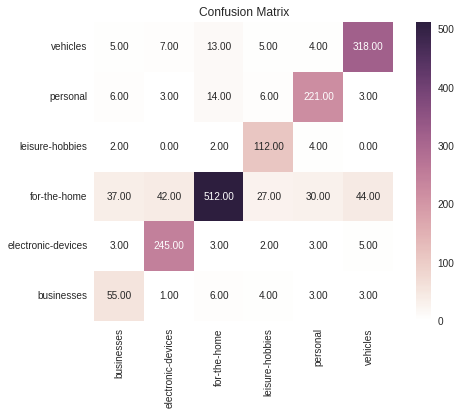

In [ ]:
mpl.style.use('seaborn')

conf_arr = np.zeros((num_classes, num_classes))

for i in range(len(pred_test1_one_vs_all)):
        conf_arr[pred_test1_one_vs_all[i]][Y_test[i]] += 1

print(conf_arr)

summ = conf_arr.sum()

#conf_arr = conf_arr * 100.0 / ( 1.0 * summ )

df_cm = pd.DataFrame(conf_arr, 
  index = unique_cat1,
  columns = unique_cat1)

fig = plt.figure()

plt.clf()

ax = fig.add_subplot(111)
ax.set_aspect(1)

cmap = sb.cubehelix_palette(light=1, as_cmap=True)

res = sb.heatmap(df_cm, annot=True, vmin=0.0, vmax=np.max(conf_arr), fmt='.2f', cmap=cmap)

res.invert_yaxis()

plt.yticks([0.5,1.5,2.5,3.5,4.5,5.5], unique_cat1,va='center')

print('\n\n')

plt.title('Confusion Matrix')

plt.savefig('confusion_matrix.png', dpi=700, bbox_inches='tight' )

plt.show()

### 6.2) Accuracy

$$\text{Accuracy} = \frac{TP + TN}{TP + FP + FN + TN}$$

In [ ]:
# Compute the accuracy of the training data and validation data

corrects = 0
for i in range(len(pred_train1_one_vs_all)):
    if int(Y_t[i]) is int(pred_train1_one_vs_all[i]):
        corrects += 1
        
accuracy = float(corrects / len(pred_train1_one_vs_all))*100
print('Training dataset accuracy (using "{}" column): {} %'.format (column1, accuracy))

corrects = 0
for i in range(len(pred_test1_one_vs_all)):
    if int(Y_test[i]) is int(pred_test1_one_vs_all[i]):
        corrects += 1
        
accuracy = float(corrects / len(Y_test))*100

print ('Validation dataset accuracy (using "{}" column): {} % '.format (column1, accuracy))

#print 'Test datast accuracy: %f' % (np.mean(y_test == pred_test_one_vs_all))


Training dataset accuracy (using "title" column): 96.0408163265306 %
Validation dataset accuracy (using "title" column): 83.6 % 


### 6.3) Precision

$$\text{Precision} = \frac{TP}{TP + FP}$$

In [ ]:
#Similar to the binary case, we can define precision for each of the classes
precision = []
#we append the precision for each class to the variable 'precision'
for i in range(num_classes):
  precision.append(conf_arr[i][i] / np.sum(conf_arr[i], axis = 0))

print('Precisions per classes are : {}'.format(precision))

macro_precision = 100 * np.sum(precision) / num_classes

print('Macro averaged Precision is : {} %'.format(macro_precision))

weighted_precision = 0
total = 0
for i in range(num_classes):
  weighted_precision += np.sum(conf_arr, axis = 0)[i] * precision[i]
  total += np.sum(conf_arr, axis = 0)[i]

weighted_precision = 100 * weighted_precision / total
print('Weighted Precision is : {} %'.format(weighted_precision))

Precisions per classes are : [0.7638888888888888, 0.9386973180076629, 0.7398843930635838, 0.9333333333333333, 0.8735177865612648, 0.9034090909090909]
Macro averaged Precision is : 85.87884684606372 %
Weighted Precision is : 84.75554407423319 %


### 6.4) Recall

$$\text{Recall} = \frac{TP}{TP + FN}$$

In [ ]:
#Similar to the binary case, we can define recall for each of the classes
recall = []
#We append the recall for each class to the variable 'recall'
for i in range(num_classes):
  recall.append(conf_arr[i][i] / np.sum(conf_arr, axis = 0)[i])
  
print('Recalls per classes are : {}'.format(recall))

macro_recall = 100 * np.sum(recall) / num_classes
print('Macro averaged Recall is : {} %'.format(macro_recall))

weighted_recall = 0
for i in range(num_classes):
  weighted_recall += np.sum(conf_arr, axis = 0)[i] * recall[i]

weighted_recall = 100 * weighted_recall / total
print('Weighted Recall is : {} %'.format(weighted_recall))  

Recalls per classes are : [0.5092592592592593, 0.8221476510067114, 0.9309090909090909, 0.717948717948718, 0.8339622641509434, 0.8525469168900804]
Macro averaged Recall is : 77.77956500274672 %
Weighted Recall is : 83.6 %


### 6.5) F1 score

$$\text{F1 score} = 2\times \frac{(Recall \times  Precision)}{Recall + Precision}$$ 

In [ ]:
#F1-score is a function of precision and recall
#we can now compute the per-class F1-score
f1_score = []
for i in range(num_classes):
  f1_score.append( 2*( (recall[i]*precision[i]) / (recall[i]+precision[i])))

print('F1-scores per classes are : {}'.format(f1_score))

macro_f1 = 100 * np.sum(f1_score) / num_classes

print('Macro averaged F1-score is : {} %'.format(macro_f1))

weighted_f1 = 0
for i in range(num_classes):
  weighted_f1 += np.sum(conf_arr, axis = 0)[i] * f1_score[i]

weighted_f1 = 100 * weighted_f1 / total
print('Weighted F1-score is : {} %'.format(weighted_f1))  

F1-scores per classes are : [0.6111111111111112, 0.8765652951699464, 0.8244766505636071, 0.8115942028985509, 0.8532818532818534, 0.8772413793103448]
Macro averaged F1-score is : 80.90450820559023 %
Weighted F1-score is : 83.46388783001437 %


## 7) K-Fold Cross Validation *(Optional)*

Evaluate your model based on the K-Fold Cross Validation approach. This step is optional and has a few extra points.

In [ ]:
# Your implementation